Modern software development includes a plethora of tools and frameworks, such as build tools, code frameworks, CI/CD pipelines, containerization technologies, and platforms. These tools and frameworks typically have their own configuration files in which hundreds of configuration options are defined. The **configurability of technologies** is a double-edged sword. On the one hand, it allows developers to customize the behavior of tools and frameworks to suit their specific needs. On the other hand, it can lead to complexity and confusion, especially when there are many options to choose from or when the options are poorly documented. We will explore the configurability of technologies by approximating the configuration space of a technology and analyzing the configuration options. This way, we explore how many options a technology provides and how many of those options are actually used in practice, answering the following research questions: How well the configuration space of a techhnology adapted to the developer (too many knobs)?

In [2]:
import glob
import javaproperties
import re
import os
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Dict, Set

*How many configuration options does a technology provide?*

/var/folders/sv/pdgl__6900j8c78ybv1j2hjw0000gp/T/ipykernel_92120/1217808726.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


,Technology,Total Options,With Defaults
13,spring,1779,948
5,maven,362,101
8,mysql,315,275
14,travis,269,15
6,docker-compose,237,42
0,django,229,207
2,mongodb,152,94
10,tsconfig,129,40
1,cargo,113,61
4,github_action,83,0


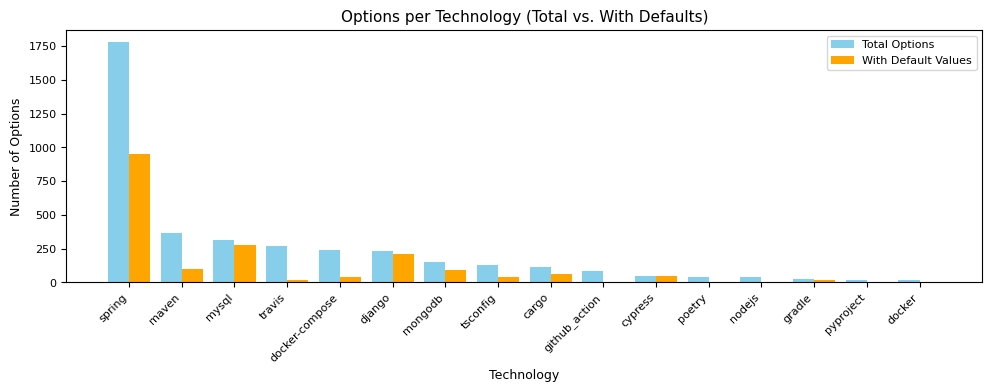

In [60]:
def show_options_per_technology(technology_files):
    data = []

    common_file_types = ["json", "yaml", "configparser"]

    for file_path in technology_files:
        technology = os.path.basename(file_path).replace(".properties", "")
        if technology in common_file_types:
            continue

        with open(file_path, "r", encoding="utf-8") as f:
            props = javaproperties.load(f)
            total = len(props)
            with_defaults = sum(1 for v in props.values() if v is not None and str(v).strip() != "")
        
        data.append((technology, total, with_defaults))

    df = pd.DataFrame(data, columns=["Technology", "Total Options", "With Defaults"])
    df.sort_values(by="Total Options", ascending=False, inplace=True)

    # Plotting grouped bars
    x = range(len(df))
    width = 0.4

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar([i - width/2 for i in x], df["Total Options"], width=width, label="Total Options", color="skyblue")
    ax.bar([i + width/2 for i in x], df["With Defaults"], width=width, label="With Default Values", color="orange")

    ax.set_xlabel('Technology', fontsize=9)
    ax.set_ylabel('Number of Options', fontsize=9)
    ax.set_title('Options per Technology (Total vs. With Defaults)', fontsize=11)
    ax.set_xticks(x)
    ax.set_xticklabels(df["Technology"], rotation=45, ha="right", fontsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.legend(fontsize=8)

    fig.tight_layout(pad=1.0)
    return fig, df

property_files = glob.glob("../data/technology/*.properties")
fig, df= show_options_per_technology(technology_files=property_files)
fig.show()
df

*How many options are actually set in a software project of a specific technologies?*

In [ ]:
def parse_properties_file(file_path: str) -> set:
    with open(file_path, "r", encoding="utf-8") as f:
        props = javaproperties.load(f)
    return set(k.strip() for k in props.keys())


def get_matches(project_options: Set[str], ref_options: Set[str]) -> Dict[str, List[str]]:
    matched_ref_to_project = {}

    for ref_opt in ref_options:
        pattern = '^' + re.escape(ref_opt).replace(r'\*', r'.+') + '$'
        regex = re.compile(pattern)
        
        matches = [opt for opt in project_options if regex.match(opt)]

        if matches:
            matched_ref_to_project[ref_opt] = matches

    return matched_ref_to_project


def get_options_per_project(technology_files: List, project_option_file: str):
    df_option = pd.read_csv(project_option_file)
    project_options = df_option.copy()
    project_options["option"] = project_options["option"].str.strip()

    # Prepare result table
    results = []

    # Iterate over all reference files
    for technology_file in technology_files:
        technology = technology_file.split("/")[-1].split(".properties")[0]
        ref_options = parse_properties_file(technology_file)

        project_subset = set(project_options[project_options["concept"].str.lower() == technology.lower()]["option"])
        
        if not project_subset:
            continue

        ref_to_proj = get_matches(project_subset, ref_options)
        matched_refs = set(ref_to_proj.keys())
        matched_project_options = sorted({opt for opts in ref_to_proj.values() for opt in opts})
        unmatched = [opt for opt in project_subset if opt not in matched_project_options]

        #print("technology:", technology)
        #print("Unmatched Options:", unmatched)

        results.append({
            "Technology": technology,
            "Project_Used": 1 if len(project_subset) > 0 else 0,
            "Total Options": len(ref_options),
            "Options Set": len(project_subset),
            "Matched Options": len(matched_refs),
            "Unmatched Options": len(unmatched),
            "Percentage Used": round(len(matched_refs) / len(ref_options) * 100, 2) if ref_options else 0.0,
            "Matched": list(matched_project_options)            
        })


    return pd.DataFrame(results)

property_files = glob.glob("../data/technology/*.properties")
project_option_file = "../data/options/test_projects/piggymetrics_options_latest.csv"
df = get_options_per_project(technology_files=property_files, project_option_file=project_option_file)
df


,Technology,Project_Used,Total Options,Options Set,Matched Options,Unmatched Options,Percentage Used,Matched
0,docker,1,18,6,6,0,33.33,"[ADD, CMD, ENTRYPOINT, EXPOSE, FROM, RUN]"
1,maven,1,362,84,27,3,7.46,"[project.artifactId, project.build.plugins.plu..."
2,docker-compose,1,237,126,11,0,4.64,"[services.account-mongodb.build, services.acco..."
3,spring,1,1779,10,5,5,0.28,"[logging.level.org.springframework.security, s..."
4,travis,1,269,10,6,4,2.23,"[after_success, dist, env.global, language, se..."


*How many options are actally set on average of specific technologies across software projects?*

Number of Projects: 20


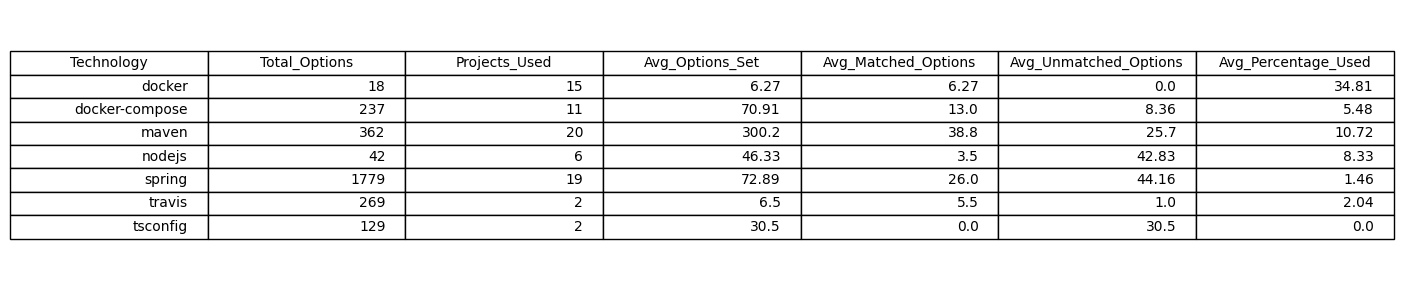

In [63]:
def get_all_project_stats(technology_files: List[str], project_option_files: List[str]) -> pd.DataFrame:
    all_results = []

    for project_file in project_option_files:
        project_name = project_file.split("/")[-1].split("_options")[0]  # adjust split pattern as needed
        df_project = get_options_per_project(technology_files, project_file)
        df_project["Project"] = project_name
        all_results.append(df_project)

    return pd.concat(all_results, ignore_index=True)


def compute_technology_averages(df: pd.DataFrame) -> pd.DataFrame:
    grouped = df.groupby("Technology").agg(
        Total_Options=("Total Options", "first"),
        Projects_Used=("Project_Used", "sum"),
        Avg_Options_Set=("Options Set", "mean"),
        Avg_Matched_Options=("Matched Options", "mean"),
        Avg_Unmatched_Options=("Unmatched Options", "mean"),
        Avg_Percentage_Used=("Percentage Used", "mean"),
    ).round(2)
    return grouped.reset_index()


property_files = glob.glob("../data/technology/*.properties")
project_files = glob.glob("../data/options/microservice_projects/*_options_latest.csv")

all_project_data = get_all_project_stats(property_files, project_files)
avg_stats = compute_technology_averages(all_project_data)

print("Number of Projects:", len(all_project_data["Project"].unique()))
avg_stats

# Create figure and add table
fig, ax = plt.subplots(figsize=(14, 3))
ax.axis("off")  # Hide axes
table = ax.table(cellText=avg_stats.values, colLabels=avg_stats.columns, loc="center")
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Optional: scale for readability

plt.tight_layout()
plt.show()

*How many options use default values?*

../data/technology/django.properties
../data/technology/cargo.properties
../data/technology/mongodb.properties
../data/technology/docker.properties
../data/technology/github_action.properties
../data/technology/maven.properties
../data/technology/docker-compose.properties
../data/technology/poetry.properties
../data/technology/mysql.properties
../data/technology/cypress.properties
../data/technology/tsconfig.properties
../data/technology/gradle.properties
../data/technology/nodejs.properties
../data/technology/spring.properties
../data/technology/travis.properties
../data/technology/pyproject.properties


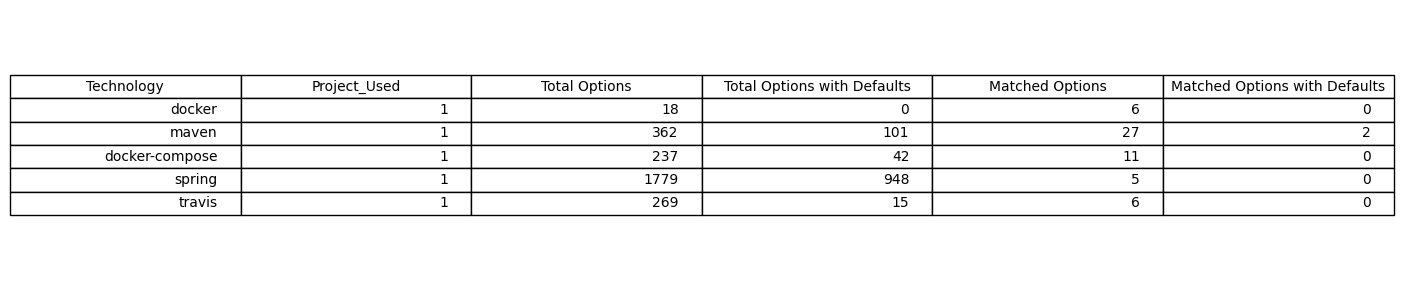

In [17]:
def get_matches(project_options_pairs: List[tuple], ref_option_pairs: Dict) -> Dict[str, List[str]]:
    matched_defaults = set()
    matched_ref_to_project = {}

    for ref_option, ref_value in ref_option_pairs.items():
        pattern = '^' + re.escape(ref_option).replace(r'\*', r'.+') + '$'
        regex = re.compile(pattern)
        
        matches = []

        for option, value in project_options_pairs:
            if regex.match(option) and value.strip() == ref_value.strip():
                matched_defaults.add((option, value))
            
            if regex.match(option):
                matches.append(option)

        if matches:
            matched_ref_to_project[ref_option] = matches

    return matched_defaults, matched_ref_to_project


def show_default_values(technology_files: List[str], project_option_file: str):
    df_option = pd.read_csv(project_option_file)
    project_options = df_option.copy()
    project_options["option"] = project_options["option"].str.strip()

    # Prepare result table
    results = []

    # Iterate over all reference files
    for technology_file in technology_files:
        print(technology_file)
        technology = technology_file.split("/")[-1].split(".properties")[0]

        with open(technology_file, "r", encoding="utf-8") as f:
            ref_option_pairs = javaproperties.load(f)
            with_defaults = sum(1 for v in ref_option_pairs.values() if v is not None and str(v).strip() != "")

        # Get options and values
        project_option_pairs = [(row["option"], row["value"]) for _, row in project_options.iterrows() if row["concept"].lower() == technology.lower()]
        
        if not project_option_pairs:
            continue

        matched_defaults, matched_options = get_matches(
            project_options_pairs=project_option_pairs, 
            ref_option_pairs=ref_option_pairs
        )

        matched_refs = set(matched_options.keys())
        matched_options_with_defaults = [option for option, _ in matched_defaults]

        results.append({
            "Technology": technology,
            "Project_Used": 1 if len(project_option_pairs) > 0 else 0,
            "Total Options": len(ref_option_pairs),
            "Total Options with Defaults": with_defaults,
            "Matched Options": len(matched_refs),
            "Matched Options with Defaults": len(matched_defaults),
            #"Matched Defaults": list(matched_options_with_defaults)            
        })


    return pd.DataFrame(results)

property_files = glob.glob("../data/technology/*.properties")
project_option_file = "../data/options/test_projects/piggymetrics_options_latest.csv"
df = show_default_values(technology_files=property_files, project_option_file=project_option_file)

fig, ax = plt.subplots(figsize=(14, 3))
ax.axis("off")  # Hide axes
table = ax.table(cellText=df.values, colLabels=df.columns, loc="center")
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Optional: scale for readability

plt.tight_layout()
plt.show()